<a href="https://colab.research.google.com/github/5655530/AIFFEL_CORE_QUEST/blob/main/GAN_Project/GAN_improved_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. 라이브러리 버전 확인**

In [1]:
import tensorflow
import imageio

print(tensorflow.__version__)
print(imageio.__version__)

2.13.0
2.31.3


## **2. 데이터셋 불러오기**

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170498071/170498071 [==============================] - 13s 0us/step


(50000, 32, 32, 3)

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


## **3. 데이터셋 정규화**

In [5]:
train_x = train_x / 127.5 - 1

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


cifar10 데이터는 컬러 이미지이므로, 채널 값은 3임. 따라서 데이터셋의 shape 마지막에 3을 추가

In [6]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

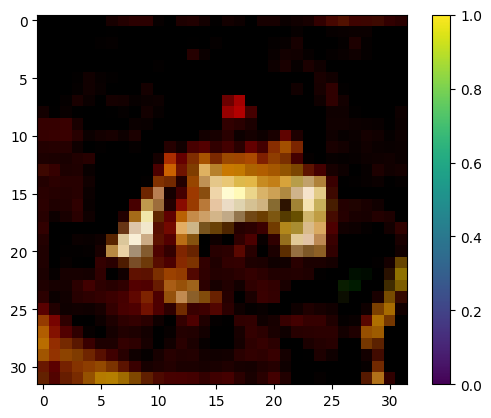

In [7]:
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

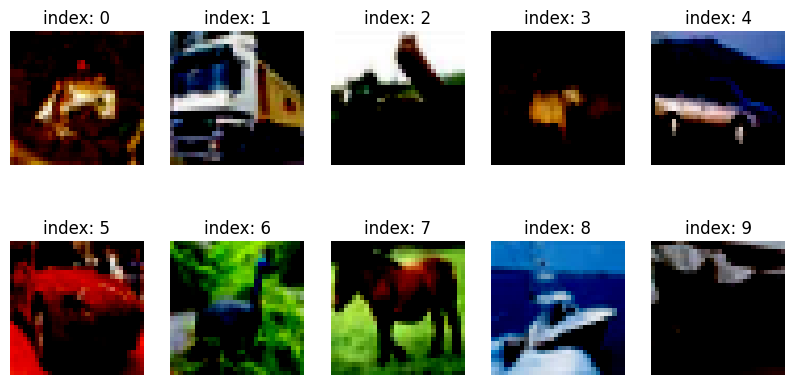

In [8]:
# 랜덤한 10개의 이미지 시각화

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [9]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## **4. 생성자 모델 생성**

In [11]:
def make_generator_model():

    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer (8x8x256 -> 16x16x128)
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer (16x16x128 -> 32x32x64)
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer (32x32x64 -> 32x32x3)
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (Batch  (None, 16384)             65536     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       5

In [13]:
# 노이즈 생성
noise = tf.random.normal([1, 100])

In [14]:
# 성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성

generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

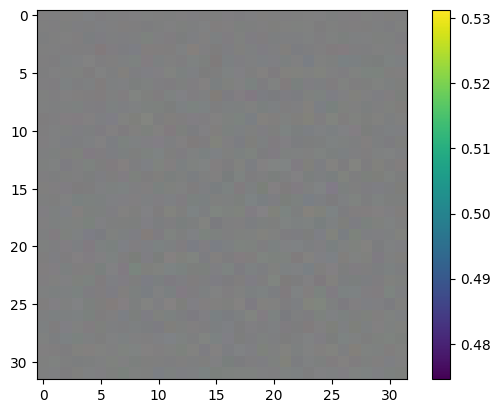

In [15]:
# 첫 번째 차원(배치 차원)을 제거
img = np.squeeze(generated_image)

# 픽셀 값을 [0, 1] 범위로 스케일링
img = (img + 1) / 2.0

plt.imshow(img)
plt.colorbar()
plt.show()

## **5. 식별자 모델 생성**

In [16]:
import tensorflow as tf
from tensorflow.keras import layers

def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [17]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
import tensorflow as tf
## real_labels와 fake_labels도 함께 전달 받도록 수정
def discriminator_loss(real_output, fake_output, real_labels, fake_labels):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [22]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## **6. 구형 샘플링 적용**
- Interpolation via a Great Circle:
이 방식은 주로 두 잠재 벡터 사이의 변화를 시각화할 때 사용됩니다. 예를 들어, 두 잠재 벡터 A와 B 사이에서 이미지를 생성하려는 경우, A와 B 사이를 직선으로 연결하는 대신 구의 표면을 따라 이동하면서 이미지를 생성합니다.

In [24]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
# 각 잠재 벡터를 정규화하여 구의 표면에 매핑
seed = tf.math.l2_normalize(seed, axis=1)
seed.shape

TensorShape([16, 100])

## **7. 훈련스텝 구현**
- Soft and Noisy Labels 적용
  - Label Smoothing:
진짜 이미지와 가짜 이미지의 레이블을 부드럽게 만듭니다. 이렇게 하면 판별자가 너무 확신을 가지지 않도록 도와줍니다.
  - Noisy Labels:
가끔 판별자에게 레이블을 무작위로 뒤집어 제공하여 학습에 노이즈를 추가합니다.

In [39]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # 출력하여 형상 확인
        print("Shape of real_output:", real_output.shape)
        print("Shape of fake_output:", fake_output.shape)

        # Soft labels
        real_labels = tf.random.uniform(minval=0.7, maxval=1.2, shape=real_output.shape)
        fake_labels = tf.random.uniform(minval=0.0, maxval=0.3, shape=fake_output.shape)

        # Noisy labels (with a small probability, e.g., 0.05)
        flip_fake = tf.random.uniform(fake_output.shape) < 0.05
        flip_real = tf.random.uniform(real_output.shape) < 0.05
        real_labels = tf.where(flip_real, 1 - real_labels, real_labels)
        fake_labels = tf.where(flip_fake, 1 - fake_labels, fake_labels)


        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output, real_labels, fake_labels)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [26]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

        plt.savefig('/content/drive/MyDrive/GAN_Project/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
            .format(epoch, it))

    plt.show()

In [27]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/GAN_Project/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

In [28]:
checkpoint_dir = '/content/drive/MyDrive/GAN_Project/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [29]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [30]:
save_every = 5
EPOCHS = 40

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## **8. 모델학습**

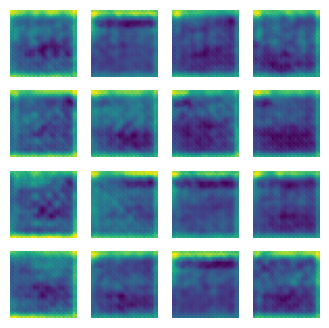

Time for training : 1355 sec


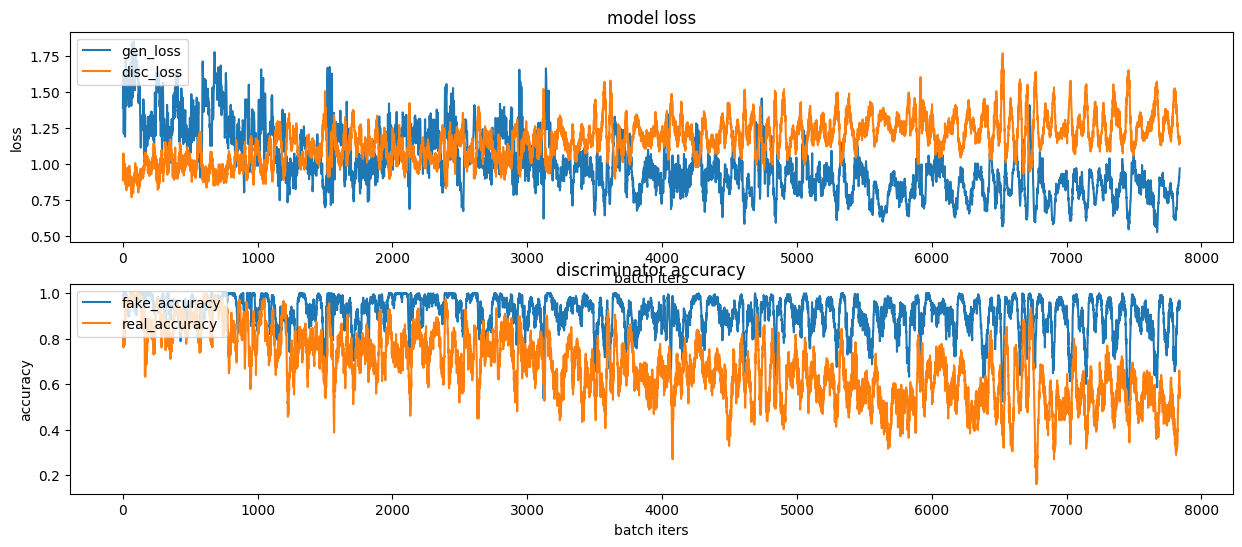

CPU times: user 8min 5s, sys: 58.7 s, total: 9min 4s
Wall time: 22min 37s


In [40]:
%%time
train(train_dataset, EPOCHS, save_every)

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **9. checkpoint를 활용하여 모델을 로드**

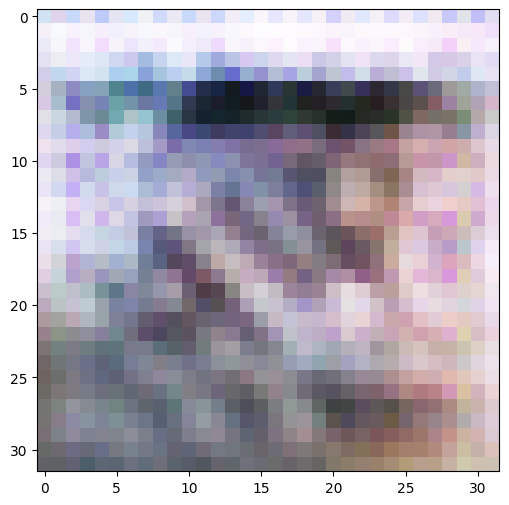

In [41]:
checkpoint_dir = '/content/sample_data/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다.
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

## **10. 회고**
- **Keep**: GAN모델을 구현함에 있어 기존에 노드에서 제공된 코드 이외에도 구형샘플링, 레이블 스무딩, 노이지 레이블등 다양한 방법들을 적용해 개선해보려 노력했다.
- **Problem**: 모델의 학습을 한번 진행할때마다 많은 시간이걸려 더욱 다양한 시도를 해볼 수 없었고, 결과적으로 개선사항을 적용한 버전과 아닌 버전의 결과에서 큰 차이를 발견 할 수 없었다.
- **Try**: 충분한 수의 에폭으로 학습을 진행해 좀더 정확한 결과의 차이를 비교해보고 싶다.